#   $\mathbb{Task ~~for ~~meet ~~at ~~28 ~~July~~ 2022}$

In [1]:
# importing all necessary library

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from tqdm import tqdm

In [2]:
# importing csv file of 1m sources containing Gaia data for plotting HR diagram

filename = '1M.csv' 
df1 = pd.read_csv(filename)

# filtering data on the basis of parallax error so that we can get better observed sources
df = df1[df1['parallax_error']< 0.1]

# extracting the value of G-K filter
g_k_1m = df['phot_g_mean_mag'] - df['ks_m']

In [3]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query1 = """SELECT TOP {}""".format(query_size) + """
        g.ra, g.dec, g.parallax, g.parallax_error, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr2.gaia_source as g, gaiadr2.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr2.tmass_best_neighbour as t, tmass_original_valid as tt
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.tmass_oid = tt.tmass_oid))
        """

    job2 = Gaia.launch_job(query1)
    result1 = job2.get_results()

    return result1

In [4]:
# Defining a function which will return GAIA's and 2MASS's data of T Tauri sources taking input of source_id of the sources

def get_Candidate_list(s_id):
    """Pass a tuple of source id of sources, it will return all required parameters values from the GAIA DR3, 2MASS"""

    query = """SELECT g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, d3.r_med_photogeo, d3.r_lo_photogeo, d3.r_hi_photogeo,(d3.r_hi_photogeo - d3.r_lo_photogeo)/(2 * d3.r_med_photogeo) AS dist_frac, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr3.gaia_source as g, gaiadr3.tmass_psc_xsc_best_neighbour as t, tmass_original_valid as tt, external.gaiaedr3_distance AS d3
        WHERE g.source_id IN {}""".format(s_id) + """ AND g.parallax > 0.0 AND
        (g.parallax IS NOT NULL) AND (g.phot_g_mean_mag IS NOT NULL) AND (g.source_id = t.source_id AND t.clean_tmass_psc_xsc_oid = tt.tmass_oid) AND (g.source_id = d3.source_id)
        """

    job = Gaia.launch_job(query)
    result = job.get_results()
    result = result.to_pandas()

    return result


In [5]:
# Extrtacting list of stars around Herbig Ae/Be Star
herbig1 = get_gaia_result(1000, 193.3217131, -77.1196488, 6./60.)
herbig1 = herbig1[herbig1['parallax_error'] < 0.3]
herbig1

ra,dec,parallax,parallax_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,w1mpro,w2mpro,w3mpro,w4mpro,j_m,h_m,ks_m
deg,deg,mas,mas,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag
float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32
193.2353580725154,-77.16902458672335,0.5042087581744774,0.07948270213765243,16.844564,19.036036,15.441963,3.5940723,5.357616363666047,10.551,10.488,10.697,9.071,12.578,11.338,10.787
193.33080734060272,-77.20145325569595,0.9386672567093418,0.16284159960799624,18.64038,20.471603,17.274887,3.1967163,8.502939203106806,12.994,12.957,12.663,9.221,14.678,13.622,13.226
193.48250745431903,-77.21117397766025,0.6366062992574363,0.17516915015553833,18.899643,20.343151,17.608974,2.7341766,7.918997602716637,14.058,14.037,12.486,9.103,15.527,14.51,14.046
193.28335786025855,-77.21249591120427,0.32674555615111955,0.2544924048974982,19.103743,20.669308,17.712132,2.9571762,6.674791048199779,13.826,13.716,12.272,7.961,15.312,14.37,13.939
193.4487609406572,-77.19730633849714,0.37616756607367474,0.2036955243216398,18.931393,20.288822,17.660078,2.6287441,6.808299405089404,14.219,14.275,12.929,9.242,15.623,14.679,14.312
193.48286402251915,-77.14559734758701,0.9319077681856984,0.2454827335222649,19.150911,20.841637,17.721092,3.1205444,8.997775990853743,13.472,13.365,11.708,9.008,15.142,14.097,13.585
193.67679217152786,-77.16422974952599,1.0716126542072004,0.17656610983295679,18.562317,20.145258,17.249495,2.8957634,8.712506061335624,13.493,13.454,12.955,9.326,15.036,14.13,13.744
193.61730307406398,-77.16923283801628,0.6601265092724227,0.16700795597262894,18.659203,20.638775,17.260548,3.3782272,7.757338442892241,13.083,12.978,12.145,9.221,14.737,13.808,13.289


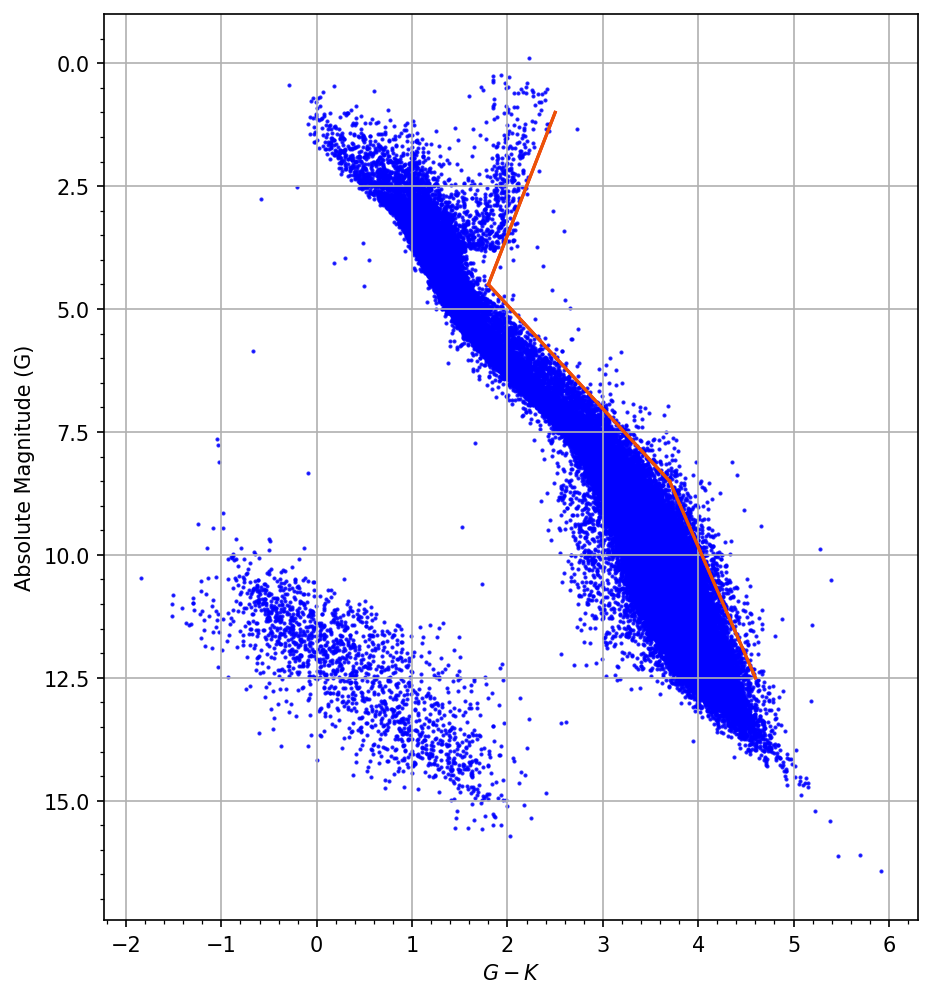

In [7]:
%matplotlib inline
her_gk = herbig1['phot_g_mean_mag'] - herbig1['ks_m']
her_mg = herbig1['mv']

# Defining the equation of straight line for the boundries
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7, 8), dpi = 150)


ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.8, c = 'blue')

# plotting the lines using just two points 
ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = '#EB5406')
ax.plot(equation2(y_values2), y_values2,  color = '#EB5406')
ax.plot(equation3(y_values3), y_values3, color = '#EB5406')

# plotting/Placing herbig's surrounding stars in HR diagram(CMD)
# ax.scatter(her_gk, her_mg, marker='o', color = 'k', s = 5, label = 'HAeBe')
#ax.scatter(g_k3, mg3, marker='+', color = 'red', s = 5, label = 'Random Star')
#ax3.colorbar(aspect = 50)
ax.minorticks_on()
ax.grid(True)
# ax3.set_xlim(min(df.bp_rp), max(df.bp_rp))
ax.set_ylim(max(df.mg)+1, -1)
plt.show()


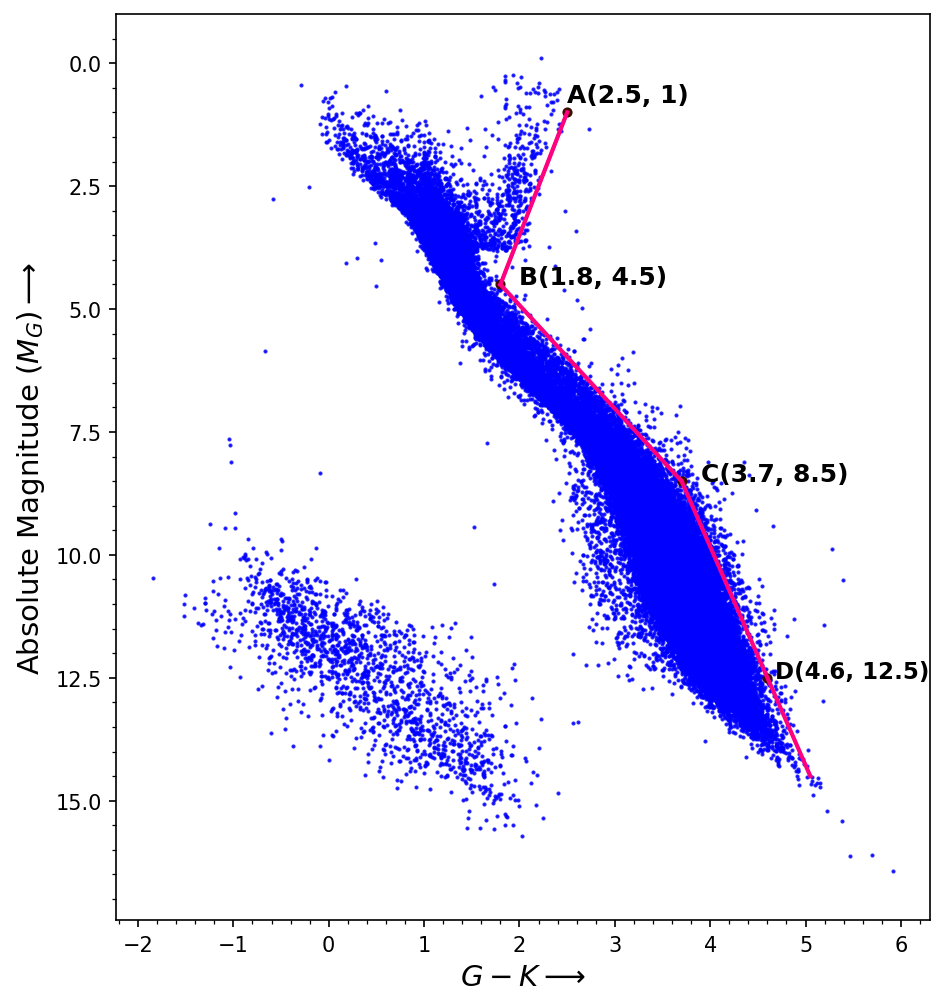

In [8]:
# Modified Date - 11 Nov 2022 for Draft Thesis

%matplotlib inline
her_gk = herbig1['phot_g_mean_mag'] - herbig1['ks_m']
her_mg = herbig1['mv']

# Defining the equation of straight line for the boundries
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 14.5, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7, 8), dpi = 150)


ax.set_xlabel(r"$G - K \longrightarrow$", fontsize = 14)
ax.set_ylabel(r"Absolute Magnitude $(M_G) \longrightarrow$", fontsize = 14)


# Plotting the HR diagram for 1M sources
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.8, c = 'blue')

# plotting the lines using just two points 
ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = '#FF007F', linewidth = 2)
ax.plot(equation2(y_values2), y_values2,  color = '#FF007F', linewidth = 2)
ax.plot(equation3(y_values3), y_values3, color = '#FF007F', linewidth = 2)

# Texting all the points in the figure

ax.text(2.5, 0.8, f"A(2.5, 1)", fontsize = 12, fontweight = 900)
ax.scatter(2.5, 1, s = 15, color = '#3D0C02')

ax.text(2, 4.5, "B(1.8, 4.5)", fontsize = 12, fontweight = 900)
ax.scatter(1.8, 4.5, s = 15, color = '#3D0C02')

ax.text(3.9, 8.5, "C(3.7, 8.5)", fontsize = 12, fontweight = 900)
ax.scatter(3.7, 8.5, s = 15, color = '#3D0C02')


ax.text(4.68, 12.5, "D(4.6, 12.5)", fontsize = 11, fontweight = 900)
ax.scatter(4.6, 12.5, s = 15, color = '#3D0C02')


ax.minorticks_on()
# ax.grid(True)
ax.set_ylim(max(df.mg)+1, -1)
# fig.savefig("CMD_line_2.jpg", dpi = 600, bbox_inches='tight')
plt.show()


In [9]:

herbig6 = get_gaia_result(1000, 73.94125, 30.51111, 6./60.)
herbig6 = herbig6[herbig6['parallax_error']< 0.3]

# a randomly choosen star 
rand_star6 = get_gaia_result(1000, 269.3511618, 34.87346648, 6./60.)
rand_star6 = rand_star6[rand_star6['parallax_error']< 0.3]


herbig10 = get_gaia_result(1000, 73.94125, 30.51111, 10./60.)
herbig10 = herbig10[herbig10['parallax_error']< 0.3]

# a randomly choosen star 
rand_star10 = get_gaia_result(1000, 269.3511618, 34.87346648, 10./60.)
rand_star10 = rand_star10[rand_star10['parallax_error']< 0.3]


In [11]:
herbig6

ra,dec,parallax,parallax_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,w1mpro,w2mpro,w3mpro,w4mpro,j_m,h_m,ks_m
deg,deg,mas,mas,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag
float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32
73.91668921333707,30.46893068447577,0.5809911828487164,0.04215421813787155,14.270304,14.845737,13.538179,1.3075581,3.0911514340239776,11.873,11.855,11.988,8.864,12.5,12.138,11.995
74.02777888551793,30.45943506355035,6.223210087955543,0.03735208653064244,13.758946,14.5730715,12.868395,1.7046766,7.72901873117268,10.484,10.492,10.482,8.84,11.507,10.781,10.56
73.9135926001072,30.452956852706276,0.2415702544440437,0.15317538998344435,16.942684,17.523897,16.175226,1.348671,3.857901457308669,14.538,14.614,12.416,8.604,15.262,14.756,14.619
73.8662031226172,30.492358557070634,0.012592393466357571,0.12466300312480841,16.984987,17.673178,16.145805,1.5273724,-2.5144713143627975,14.192,14.306,11.752,8.893,14.997,14.588,14.301
73.8543398420911,30.50501258534722,0.17420640791909253,0.15939372743535807,17.45803,18.215614,16.567423,1.6481915,3.663351329837422,14.417,14.419,12.281,8.745,15.268,14.831,14.636
73.94901684982482,30.442143104273974,1.043106452497635,0.03637340159689432,13.849195,14.449907,13.10414,1.345767,3.940837686126091,11.46,11.456,11.908,8.256,12.106,11.742,11.589
73.9898391302778,30.499424702599057,0.9692642988006345,0.2803147792185897,18.44011,19.1809,17.471954,1.7089462,8.372320335601955,15.323,15.361,12.188,8.852,16.133,15.584,15.432
74.00692115274518,30.512202677350306,0.6542643909742029,0.07205518186291826,16.149305,16.904608,15.268598,1.6360102,5.228071763672043,13.171,13.176,12.334,8.453,14.008,13.455,13.276


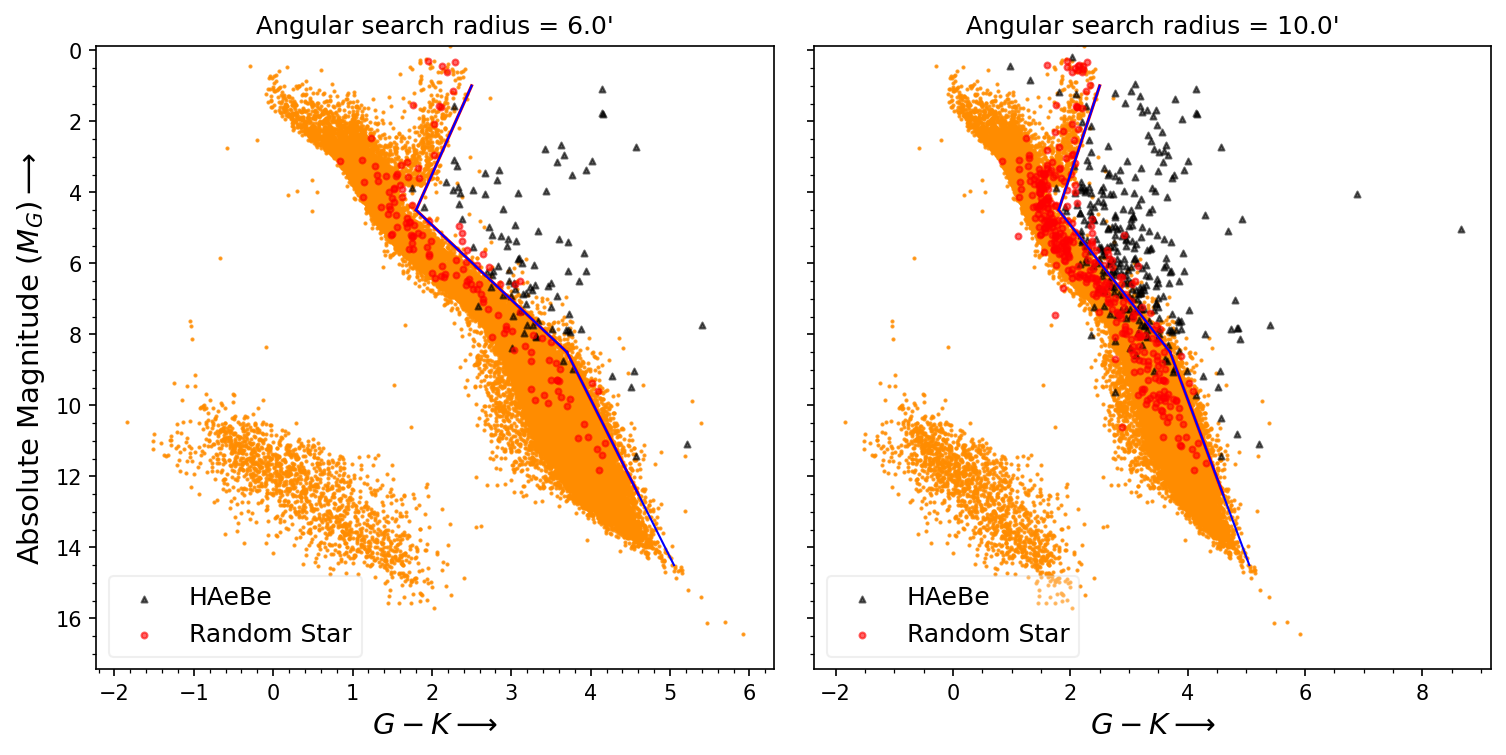

In [13]:
# Modified  by - 12 Nov 2022  for Draft Thesis
# %matplotlib inline
her_g_k_6 = herbig6["phot_g_mean_mag"] - herbig6["ks_m"]
rand_g_k_6 = rand_star6["phot_g_mean_mag"] - rand_star6["ks_m"]

her_g_k_10 = herbig10["phot_g_mean_mag"] - herbig10["ks_m"]
rand_g_k_10 = rand_star10["phot_g_mean_mag"] - rand_star10["ks_m"]
# Defining the equation of straight line for the boundries
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 14.5, 100)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12, 5.5), dpi = 150, sharey=True)


ax1.set_xlabel(r"$G - K \longrightarrow$", fontsize = 14)
ax1.set_ylabel(r"Absolute Magnitude $(M_G) \longrightarrow$", fontsize = 14)


# Plotting the HR diagram for 1M sources
ax1.scatter(g_k_1m, df.mg, s = 1, alpha = 0.8, c = '#FF8C00')

# plotting the lines using just two points 
ax1.plot([1.8, 2.5], [4.5, 1], color = 'red')
ax1.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
ax1.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax1.plot(equation1(y_values1), y_values1,  color = 'blue', linewidth = 1)
ax1.plot(equation2(y_values2), y_values2,  color = 'blue', linewidth = 1)
ax1.plot(equation3(y_values3), y_values3, color = 'blue', linewidth = 1)

# Texting all the points in the figure

ax1.scatter(her_g_k_6, herbig6["mv"], marker='^', color='k', s=8, alpha = 0.6, label='HAeBe')
ax1.scatter(rand_g_k_6, rand_star6["mv"], marker='o', color='red', s=8, alpha = 0.6, label='Random Star')
ax1.set_ylim(max(df.mg)+1, min(df.mg)-1)
ax1.legend(loc = 'lower left', fontsize = 12, framealpha = 0.3)
ax1.minorticks_on()
# ax1.grid(True)
ax1.set_ylim(max(df.mg)+1, min(df.mg))




# Plotting the HR diagram for 1M sources
ax2.scatter(g_k_1m, df.mg, s = 1, alpha = 0.8, c = '#FF8C00')

# plotting the lines using just two points 
ax2.plot([1.8, 2.5], [4.5, 1], color = 'red')
ax2.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
ax2.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax2.plot(equation1(y_values1), y_values1,  color = 'blue', linewidth = 1)
ax2.plot(equation2(y_values2), y_values2,  color = 'blue', linewidth = 1)
ax2.plot(equation3(y_values3), y_values3, color = 'blue', linewidth = 1)

# Texting all the points in the figure

ax2.scatter(her_g_k_10, herbig10["mv"], marker='^', color='k', s=8, alpha = 0.6, label='HAeBe')
ax2.scatter(rand_g_k_10, rand_star10["mv"], marker='o', color='red', s=8, alpha = 0.6, label='Random Star')
ax2.set_ylim(max(df.mg)+1, min(df.mg)-1)
ax2.legend(loc = 'lower left', fontsize = 12, framealpha = 0.3)
ax2.minorticks_on()
# ax2.grid(True)
ax2.set_ylim(max(df.mg)+1, min(df.mg))
fig.subplots_adjust(wspace=0.06)
ax1.set_title("Angular search radius = 6.0\'")
ax2.set_xlabel(r"$G - K \longrightarrow$", fontsize = 14)
ax2.set_title("Angular search radius = 10.0\'")
fig.savefig("CMD_line_with_2stars.jpg", dpi = 800, bbox_inches='tight')
plt.show()


## Counting Function 

In [14]:
# Defining a function which will count red object
# just we need to pass list of object(stars) with G-K as X- coordinate and Absolute Magnitude(Mv) as Y-coordinate 

def counting_fun(her_mg, her_gk):

    count_red = 0

    for i in range(len(her_mg)):

        if her_mg[i] <= 4.5:
            if her_gk[i] >= equation1(her_mg[i]):
                count_red = count_red + 1
        
        elif 4.5 < her_mg[i] and her_mg[i] <= 8.5:
            if her_gk[i] >= equation2(her_mg[i]):
                count_red = count_red + 1

        elif 8.5 < her_mg[i] and her_mg[i] < 12.5:
            if her_gk[i] >= equation3(her_mg[i]):
                count_red = count_red + 1


    return count_red

In [15]:
n_stars = counting_fun(her_mg, her_gk)

print("total number of stars = {}".format(n_stars))

print(len(her_gk), len(her_mg))
# for i in range(len(her_mg)):
#     print(her_mg[i], her_gk[i])

Prob_red_her = n_stars/len(her_mg)
print(Prob_red_her)

total number of stars = 53
54 54
0.9814814814814815


In [16]:
rand_star = get_gaia_result(1000, 72.77801742, 0.546141291, 12./60.)
rand_star = rand_star[rand_star['parallax_error']< 0.3]

In [17]:
rand_gk = rand_star['phot_g_mean_mag'] - rand_star['ks_m']
rand_mg = rand_star['mv']

In [18]:
rand_count = counting_fun(rand_mg, rand_gk)
rand_count

33

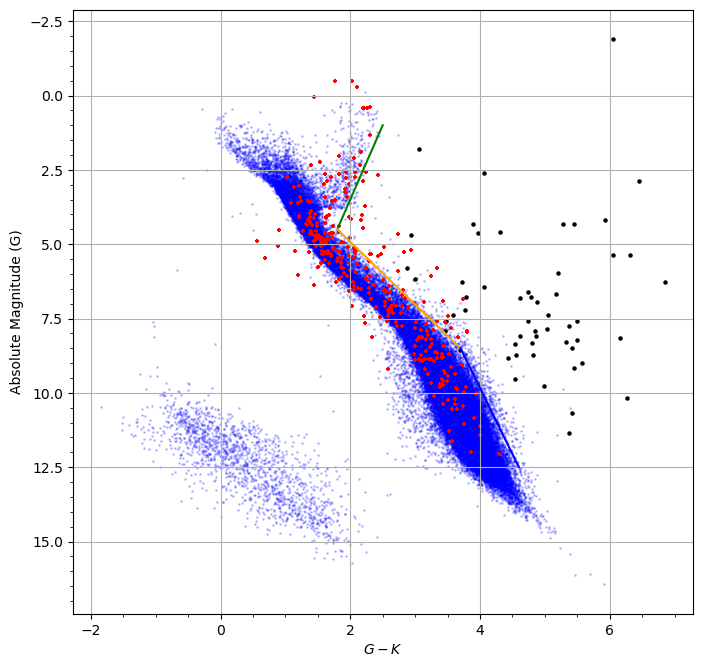

In [19]:
%matplotlib inline

her_gk = herbig1['phot_g_mean_mag'] - herbig1['ks_m']
her_mg = herbig1['mv']
def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x

# x_values1 = np.linspace(1.8, 2.5, 50)
# x_values2 = np.linspace(1.8, 3.7, 100)
# x_values3 = np.linspace(3.7, 12.5, 100)


y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 12.5, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)
ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)")
ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')
ax.plot(equation1(y_values1), y_values1,  color = 'green')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')

ax.plot(equation3(y_values3), y_values3, color = 'blue')

ax.scatter(her_gk, her_mg, marker='o', color = 'k', s = 5, label = 'HAeBe')

ax.scatter(rand_gk, rand_mg, marker='+', color = 'red', s = 5, label = 'Random Star')

ax.minorticks_on()
ax.grid(True)
# ax3.set_xlim(min(df.bp_rp), max(df.bp_rp))
ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
plt.show()


In [20]:
df

,source_id,parallax,ra,dec,parallax_error,duplicated_source,astrometric_excess_noise,astrometric_excess_noise_sig,phot_g_mean_flux,phot_g_mean_flux_error,...,cc_flags,ext_flag,var_flag,ph_qual,j_m,h_m,ks_m,j_msigcom,h_msigcom,ks_msigcom
0,3231411455095920256,10.000035,72.778017,0.546141,0.074407,False,0.521312,80.675951,5.389042e+04,41.505661,...,0000,0,000n,AAAU,11.496,10.939,10.729,0.024,0.026,0.021
3,59856764476922752,10.000128,47.433495,19.411508,0.076575,False,0.310817,5.814348,7.947432e+03,7.082393,...,0000,0,00nn,AACU,13.000,12.430,12.171,0.021,0.019,0.021
4,2491977962585908224,10.000153,28.671080,-4.863804,0.032217,False,0.119519,2.913026,6.589999e+04,49.558418,...,0000,0,011n,AAAU,11.329,10.677,10.471,0.024,0.025,0.023
5,1563374697110205312,10.000179,201.493092,53.628709,0.022360,False,0.151047,6.187992,6.800197e+04,17.079007,...,0000,0,000n,AAAU,11.247,10.597,10.390,0.021,0.018,0.016
6,2379480468317421568,10.000182,347.304308,-26.763627,0.066693,False,0.454011,49.354061,1.080763e+05,41.752209,...,0000,0,000n,AAAB,10.682,10.064,9.837,0.025,0.023,0.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198540,2552928187080872832,231.737500,12.296568,5.376933,0.037960,False,0.000000,0.000000,2.241163e+05,30.054072,...,0000,1,20nn,AABU,11.688,11.572,11.498,0.022,0.024,0.025
198543,6583272171335359360,251.829492,319.295599,-38.872297,0.055867,False,0.000000,0.611974,7.679149e+07,43875.705595,...,0h00,1,nn10,UUAA,4.046,3.256,3.100,0.266,0.216,0.230
198544,385334230892516480,280.690239,4.612668,44.024730,0.042903,False,0.000000,0.000000,2.448316e+07,11426.201113,...,hhh0,1,0100,CBAA,5.252,4.476,4.018,0.264,0.200,0.020
198545,3796072592206250624,296.307292,176.937604,0.799290,0.069922,False,0.188976,13.182416,2.748394e+06,2835.046162,...,HHH0,0,nnn0,BAAA,6.505,5.945,5.654,0.023,0.024,0.024


## Importing list of 20 Herbig Ae/Be and Random Stars

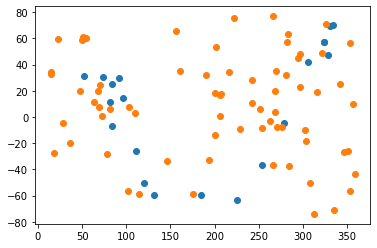

In [21]:
# importing 20 Herbig Stars

herbig_list = pd.read_csv("Herbig20.csv")
herbig_20 = herbig_list[["Name", "RAICRS", "DEICRS", "Dist"]].copy()

# taking 20 random stars from Gaia Database
randstar_20 = df[["ra", "dec", "source_id"]].head(70)
randstar_20 = randstar_20.reset_index(drop=True)
plt.scatter(herbig_20.RAICRS, herbig_20.DEICRS)
plt.scatter(randstar_20.ra, randstar_20.dec)
plt.show()


In [22]:
randstar_20

,ra,dec,source_id
0,72.778017,0.546141,3231411455095920256
1,47.433495,19.411508,59856764476922752
2,28.671080,-4.863804,2491977962585908224
3,201.493092,53.628709,1563374697110205312
4,347.304308,-26.763627,2379480468317421568
...,...,...,...
65,266.000093,-36.604013,4040895859906077952
66,70.517015,24.010726,146848750077282816
67,326.351611,70.956487,2224593674063087872
68,294.475711,44.983834,2079902685497604480


In [23]:
source_id = randstar_20["source_id"]
tuple(source_id)
randstar_20 = get_Candidate_list(tuple(source_id))
randstar_20 = randstar_20.head(20)
randstar_20 = randstar_20.reset_index(drop=True)

In [24]:
randstar_20

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,dist_frac,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,j_m,h_m,ks_m
0,59856764476922752,47.433523,19.411503,9.890270,0.046848,100.436653,99.850952,100.966087,0.005551,15.907440,17.483391,14.698281,2.785110,10.883481,16.246000,15.561,15.306000
1,146848750077282816,70.517012,24.010725,10.107328,0.022312,98.561348,98.384552,98.830284,0.002261,7.086922,7.316390,6.694567,0.621823,2.110103,14.498000,13.742,13.620000
2,312981486700500096,14.193589,32.494459,9.936203,0.017288,100.188339,100.026398,100.347954,0.001605,13.773635,14.741076,12.802568,1.938507,8.759737,14.319000,14.165,14.103000
3,362748097393004416,14.984224,34.442297,10.005069,0.045070,99.514137,98.984550,100.051117,0.005359,15.859979,17.362728,14.664412,2.698317,10.861079,13.987000,13.745,13.693000
4,461687651222322432,49.749567,58.439481,9.964083,0.017617,99.953873,99.785797,100.128395,0.001714,13.964098,15.074608,12.915493,2.159115,8.956285,16.856001,15.956,15.580000
5,462576778173176576,50.643719,60.716856,10.078152,0.023823,98.821953,98.621704,99.038483,0.002109,14.939083,16.326674,13.775648,2.551025,9.955988,16.554001,15.817,15.673000
6,474381856563417088,54.307283,60.575474,10.003175,0.039693,99.493614,99.105797,99.823410,0.003606,15.981009,17.867199,14.681762,3.185437,10.981699,10.538000,9.730,9.550000
7,509413529674071680,22.703879,59.702555,10.033937,0.019883,99.345024,99.174324,99.525673,0.001768,11.221929,11.753500,10.540051,1.213449,6.229286,15.563000,15.067,14.583000
8,750300897934316416,160.450729,34.777272,10.129899,0.045577,98.254036,97.922775,98.614243,0.003519,16.123632,17.706575,14.910587,2.795988,11.151658,16.643000,15.914,16.356001
9,1053784627100127872,156.682076,65.710861,9.807779,0.041711,101.486702,101.077377,101.971992,0.004408,16.119411,17.783390,14.857485,2.925905,11.077265,15.251000,14.630,14.318000


In [25]:
one_coord = SkyCoord(df.ra, df.dec, unit = (u.deg, u.deg))
herb_coord= SkyCoord(herbig_20.RAICRS, herbig_20.DEICRS, unit = (u.deg, u.deg))
rand_coord = SkyCoord(randstar_20.ra, randstar_20.dec, unit = (u.deg, u.deg))


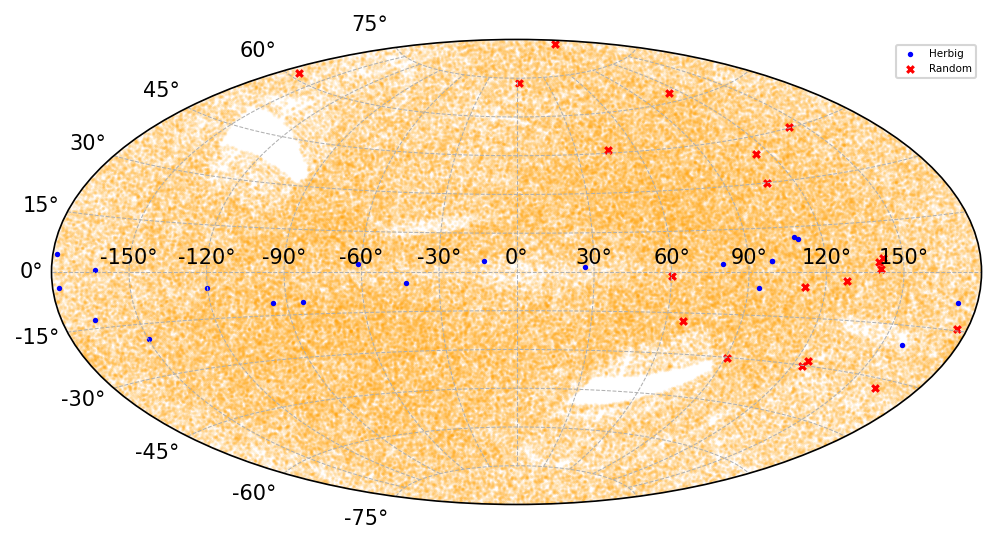

In [26]:
# Converting to galactic coordinate in degrees


one_gal = one_coord.transform_to('galactic')
herb_gal = herb_coord.transform_to('galactic')
rand_gal = rand_coord.transform_to('galactic')


l_one = one_gal.l.radian
l_one[l_one > np.pi] -= 2.0*np.pi
b_one = one_gal.b.radian


l_herb = herb_gal.l.radian
l_herb[l_herb > np.pi] -= 2.0*np.pi
b_herb = herb_gal.b.radian



l_rand = rand_gal.l.radian
l_rand[l_rand > np.pi] -= 2.0*np.pi
b_rand = rand_gal.b.radian


fig = plt.figure(figsize = [8, 5], dpi = 150)
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
ax.scatter(l_one, b_one, s = 0.5, color = 'orange', alpha = 0.10 )
ax.scatter(l_herb, b_herb, s = 10, color ='blue', marker = '.', label = 'Herbig')
ax.scatter(l_rand, b_rand, s = 10, color = 'red', marker = "x", label = 'Random')
ax.legend(fontsize = 5)
ax.minorticks_on()
ax.grid(True, linewidth = 0.5, linestyle = '--')
# plt.savefig('posi_stars.png', dpi = 600)
plt.show()

In [27]:
randstar_20

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,dist_frac,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,j_m,h_m,ks_m
0,59856764476922752,47.433523,19.411503,9.890270,0.046848,100.436653,99.850952,100.966087,0.005551,15.907440,17.483391,14.698281,2.785110,10.883481,16.246000,15.561,15.306000
1,146848750077282816,70.517012,24.010725,10.107328,0.022312,98.561348,98.384552,98.830284,0.002261,7.086922,7.316390,6.694567,0.621823,2.110103,14.498000,13.742,13.620000
2,312981486700500096,14.193589,32.494459,9.936203,0.017288,100.188339,100.026398,100.347954,0.001605,13.773635,14.741076,12.802568,1.938507,8.759737,14.319000,14.165,14.103000
3,362748097393004416,14.984224,34.442297,10.005069,0.045070,99.514137,98.984550,100.051117,0.005359,15.859979,17.362728,14.664412,2.698317,10.861079,13.987000,13.745,13.693000
4,461687651222322432,49.749567,58.439481,9.964083,0.017617,99.953873,99.785797,100.128395,0.001714,13.964098,15.074608,12.915493,2.159115,8.956285,16.856001,15.956,15.580000
5,462576778173176576,50.643719,60.716856,10.078152,0.023823,98.821953,98.621704,99.038483,0.002109,14.939083,16.326674,13.775648,2.551025,9.955988,16.554001,15.817,15.673000
6,474381856563417088,54.307283,60.575474,10.003175,0.039693,99.493614,99.105797,99.823410,0.003606,15.981009,17.867199,14.681762,3.185437,10.981699,10.538000,9.730,9.550000
7,509413529674071680,22.703879,59.702555,10.033937,0.019883,99.345024,99.174324,99.525673,0.001768,11.221929,11.753500,10.540051,1.213449,6.229286,15.563000,15.067,14.583000
8,750300897934316416,160.450729,34.777272,10.129899,0.045577,98.254036,97.922775,98.614243,0.003519,16.123632,17.706575,14.910587,2.795988,11.151658,16.643000,15.914,16.356001
9,1053784627100127872,156.682076,65.710861,9.807779,0.041711,101.486702,101.077377,101.971992,0.004408,16.119411,17.783390,14.857485,2.925905,11.077265,15.251000,14.630,14.318000


In [28]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star


    for i in range(len(herbig_20.RAICRS)):

        herbig_star = get_gaia_result(1000, herbig_20.loc[i][1], herbig_20.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        rand_star = get_gaia_result(1000, randstar_20.loc[i][2], randstar_20.loc[i][3], radius)
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]

        y_values1 = np.linspace(1, 4.5, 50)
        y_values2 = np.linspace(4.5, 8.5, 100)
        y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe')

        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'green')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'green')



        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)
        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)

        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)
        # print(i)

        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand
    
    


In [29]:
rad_arcmin = 5.0
all_list = list_red_object(rad_arcmin/60.0)

In [30]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]


In [31]:
# Modified Date:- 20 Sept 2022

# Creating list for storing the fractional values of red star after and before the distance filter

frac_herb = []
frac_rand = []


for i in range(len(num_red_star_her)):

    # THIS IS FOR HERBIG STARS
    if num_tot_star_her[i] == 0:
        f1 = 0.0
        frac_herb.append(f1)

    else:
        f1 = num_red_star_her[i]/num_tot_star_her[i]
        frac_herb.append(f1)
    

    # THIS IS FOR RANDOM STAR

    if num_tot_star_rand[i] == 0:
        f1 = 0.0
        frac_rand.append(f1)

    else:
        f1 = num_red_star_rand[i]/num_tot_star_rand[i]
        frac_rand.append(f1)
    


her_avg_frac = np.average(frac_herb)
rand_avg_frac= np.average(frac_rand)



In [32]:
print("\n")
print("-------------------------------   For Herbig Star    -----------------------------------")
print("\n")
print("Name of Herbig Star \t No of Red star    Total no of star    Fraction of red object")
print("-----------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:10s}\t". format(herbig_20.loc[i][0]) + "\t \t {:3d}".format(num_red_star_her[i]) + "\t \t{:3d}".format(num_tot_star_her[i]) + "\t \t \t{:0.4f}".format(num_red_star_her[i]/num_tot_star_her[i]))

print("\n")
print(" Average fraction of red objects around a Herbig Star = ", her_avg_frac)


print(" ")


print("-----------------------------------------------------------------------------------------")
print("\n")
print("--------------------------------  For Random Star    ------------------------------------")
print("\n")
print("Sl. No. of Random Star \t No of Red star    Total no of star     Fraction of red object")
print("------------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:2d}\t".format(i) + "\t \t {}\t".format(num_red_star_rand[i]) + "\t \t{}".format(num_tot_star_rand[i]) + "\t \t \t{:0.4f}".format(num_red_star_rand[i]/num_tot_star_rand[i]))

print("\n")

print(" Average fraction of red objects around a Random Star = ", rand_avg_frac)



-------------------------------   For Herbig Star    -----------------------------------


Name of Herbig Star 	 No of Red star    Total no of star    Fraction of red object
-----------------------------------------------------------------------------------------
 AB Aur    		 	  46	 	 54	 	 	0.8519
 AK Sco    		 	 256	 	268	 	 	0.9552
 AS 310    		 	  69	 	 71	 	 	0.9718
 AS 470    		 	 172	 	202	 	 	0.8515
 AS 477    		 	 110	 	144	 	 	0.7639
 BD+30 549 		 	  11	 	 12	 	 	0.9167
 BD+41 3731		 	  34	 	 54	 	 	0.6296
 BF Ori    		 	   9	 	 15	 	 	0.6000
 BH Cep    		 	  99	 	168	 	 	0.5893
 BO Cep    		 	  91	 	158	 	 	0.5759
 CO Ori    		 	  51	 	 79	 	 	0.6456
 CPM 25    		 	  88	 	205	 	 	0.4293
 CQ Tau    		 	 108	 	146	 	 	0.7397
 DG Cir    		 	 107	 	125	 	 	0.8560
 GSC 1876-0892		 	  95	 	192	 	 	0.4948
 GSC 3975-0579		 	 178	 	212	 	 	0.8396
 GSC 6546-3156		 	 160	 	243	 	 	0.6584
 GSC 8143-1225		 	  86	 	181	 	 	0.4751
 GSC 8581-2002		 	 144	 	188	 	 	0.7660
 GSC 8645-1401		

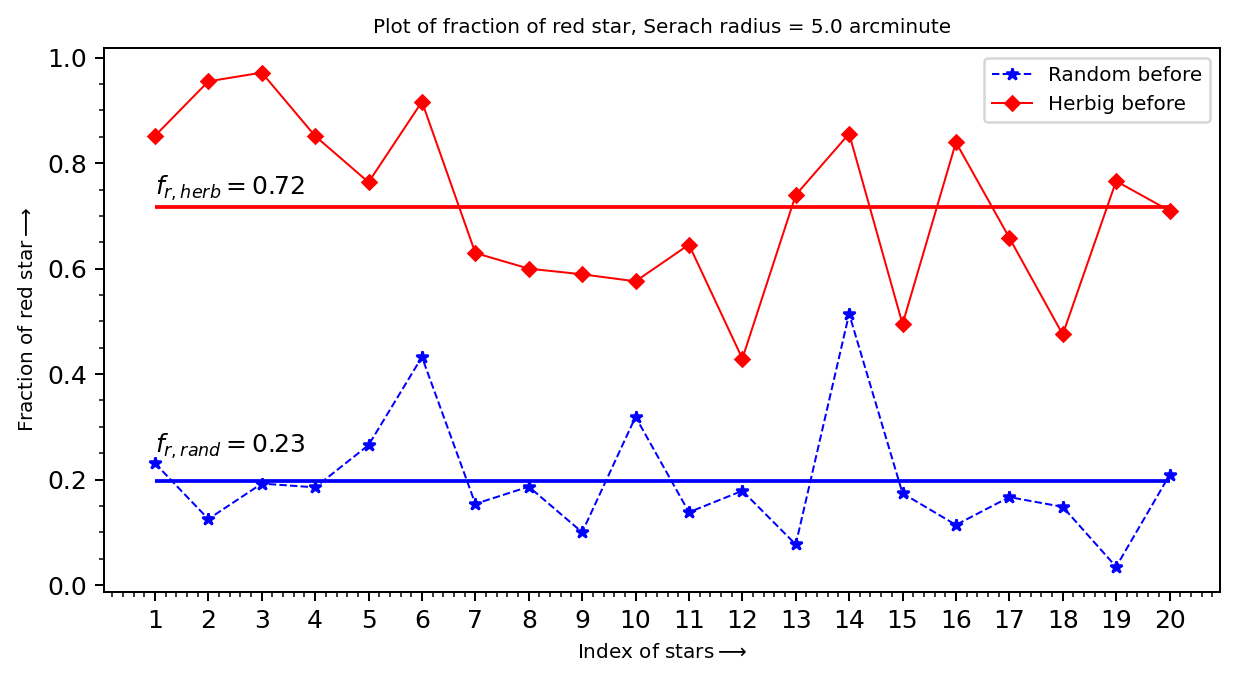

In [33]:
### MODIFIED DATE 26 Sep 2022
x_lab = range(1, 21)

fig, ax = plt.subplots(figsize = [8, 4],dpi = 180)
ax.set_xlabel(r"Index of stars$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)

ax.plot(x_lab, frac_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before", color = 'blue')
# ax.plot(range(20), frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after")
ax.hlines(np.average(frac_rand), 1, 20, color = 'blue')

ax.plot(x_lab, frac_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before", color = 'red')
# ax.plot(range(20), frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after")
ax.hlines(np.average(frac_herb), 1, 20, color = 'red')
# plt.gca().axes.get_xaxis().set_visible(False)
ax.legend(fontsize = 8)
ax.text(1, 0.74, r'$f_{r, herb} = 0.72$')
ax.text(1, 0.25, r'$f_{r, rand} = 0.23$')
# ax.set_xscale("log")
ax.set_xticks(x_lab)
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star, Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()

### MODIFIED DATE 26 Sep 2022

In [34]:
np.average(frac_herb)

0.7160083361940452

In [35]:
round(np.sqrt(np.var(frac_herb)), 2)

0.16

In [36]:
round(np.average(frac_rand), 2)

0.2

In [37]:
round(np.sqrt(np.var(frac_rand)), 2)

0.11

In [38]:
randstar_20

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,dist_frac,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,j_m,h_m,ks_m
0,59856764476922752,47.433523,19.411503,9.890270,0.046848,100.436653,99.850952,100.966087,0.005551,15.907440,17.483391,14.698281,2.785110,10.883481,16.246000,15.561,15.306000
1,146848750077282816,70.517012,24.010725,10.107328,0.022312,98.561348,98.384552,98.830284,0.002261,7.086922,7.316390,6.694567,0.621823,2.110103,14.498000,13.742,13.620000
2,312981486700500096,14.193589,32.494459,9.936203,0.017288,100.188339,100.026398,100.347954,0.001605,13.773635,14.741076,12.802568,1.938507,8.759737,14.319000,14.165,14.103000
3,362748097393004416,14.984224,34.442297,10.005069,0.045070,99.514137,98.984550,100.051117,0.005359,15.859979,17.362728,14.664412,2.698317,10.861079,13.987000,13.745,13.693000
4,461687651222322432,49.749567,58.439481,9.964083,0.017617,99.953873,99.785797,100.128395,0.001714,13.964098,15.074608,12.915493,2.159115,8.956285,16.856001,15.956,15.580000
5,462576778173176576,50.643719,60.716856,10.078152,0.023823,98.821953,98.621704,99.038483,0.002109,14.939083,16.326674,13.775648,2.551025,9.955988,16.554001,15.817,15.673000
6,474381856563417088,54.307283,60.575474,10.003175,0.039693,99.493614,99.105797,99.823410,0.003606,15.981009,17.867199,14.681762,3.185437,10.981699,10.538000,9.730,9.550000
7,509413529674071680,22.703879,59.702555,10.033937,0.019883,99.345024,99.174324,99.525673,0.001768,11.221929,11.753500,10.540051,1.213449,6.229286,15.563000,15.067,14.583000
8,750300897934316416,160.450729,34.777272,10.129899,0.045577,98.254036,97.922775,98.614243,0.003519,16.123632,17.706575,14.910587,2.795988,11.151658,16.643000,15.914,16.356001
9,1053784627100127872,156.682076,65.710861,9.807779,0.041711,101.486702,101.077377,101.971992,0.004408,16.119411,17.783390,14.857485,2.925905,11.077265,15.251000,14.630,14.318000


### $\textbf{Calculating average number of red star for diffrent radius}$

In [39]:
search_radius = np.arange(2, 10.1, 2.0)/60
avg_star_her = []
avg_star_rand = []

for i in range(len(search_radius)):

    all_list = list_red_object(search_radius[i])

    num_red_star_her = all_list[0]
    num_red_star_rand = all_list[2]
    

    avg_her = np.average(num_red_star_her)
    avg_rand = np.average(num_red_star_rand)
    avg_star_her.append(avg_her)
    avg_star_rand.append(avg_rand)


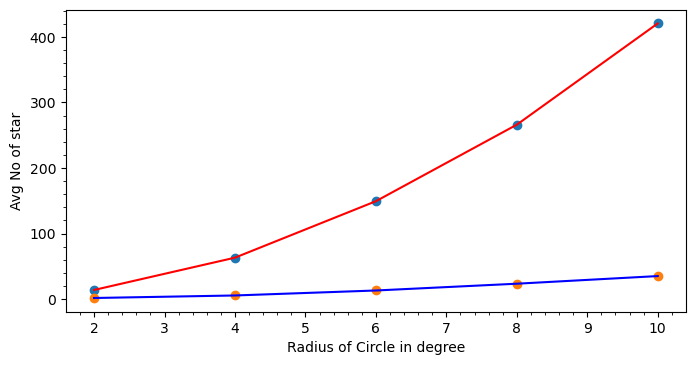

[13.85, 63.15, 149.3, 266.05, 420.5] [1.6, 5.45, 13.05, 23.4, 35.05]


In [40]:
search_radius = np.arange(2.0, 10.1, 2.0)

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (8, 4), dpi = 100)
ax.plot(search_radius, avg_star_her, c = 'red')
ax.plot(search_radius, avg_star_rand, c = 'blue')
ax.scatter(search_radius, avg_star_her)
ax.scatter(search_radius, avg_star_rand)
ax.minorticks_on()
# ax.grid()

ax.set_xlabel("Radius of Circle in degree")
ax.set_ylabel("Avg No of star")

plt.show()

print(avg_star_her, avg_star_rand)

### $\textbf{Calculating average fraction of red star for diffrent radius}$

Modified Date:- 20 Sept 2022 

In [41]:
search_radius = np.arange(2, 10.1, 2.0)/60
avg_frac_star_her = []
avg_frac_star_rand = []
sigma_herb = []
sigma_rand = []

for i in tqdm(range(len(search_radius))):

    all_list = list_red_object(search_radius[i])

    num_red_star_her = all_list[0]
    num_tot_star_her = all_list[1]
    num_red_star_rand = all_list[2]
    num_tot_star_rand = all_list[3]

    # Modified Date:- 20 Sept 2022

    # Creating list for storing the fractional values of red star after and before the distance filter

    frac_herb = []
    frac_rand = []


    for i in range(len(num_red_star_her)):

        # THIS IS FOR HERBIG STARS
        if num_tot_star_her[i] == 0:
            f1 = 0.0
            frac_herb.append(f1)

        else:
            f1 = num_red_star_her[i]/num_tot_star_her[i]
            frac_herb.append(f1)
        

        # THIS IS FOR RANDOM STAR

        if num_tot_star_rand[i] == 0:
            f1 = 0.0
            frac_rand.append(f1)

        else:
            f1 = num_red_star_rand[i]/num_tot_star_rand[i]
            frac_rand.append(f1)
        

    
    her_avg_frac = np.average(frac_herb)
    rand_avg_frac= np.average(frac_rand)

    avg_frac_star_her.append(her_avg_frac)
    avg_frac_star_rand.append(rand_avg_frac)

    # Calculating the standard deviation 
    sig_hrb = np.sqrt(np.var(frac_herb))
    sig_rnd = np.sqrt(np.var(frac_rand))

    sigma_herb.append(sig_hrb)
    sigma_rand.append(sig_rnd)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:06<00:00, 37.30s/it]


In [42]:
sigma_rand

[0.1717742864623132,
 0.08571214060809237,
 0.11441397858531656,
 0.10947796991995017,
 0.11701197905130882]

In [43]:
sigma_rand_lower = []
sigma_rand_upper = []
for i in range(len(avg_frac_star_rand)):
    diff = (avg_frac_star_rand[i] - sigma_rand[i])
    if diff < 0.0:
        sigma_rand_lower.append(avg_frac_star_rand[i])
        sigma_rand_upper.append(sigma_rand[i])
    else:
        sigma_rand_lower.append(sigma_rand[i])
        sigma_rand_upper.append(sigma_rand[i])

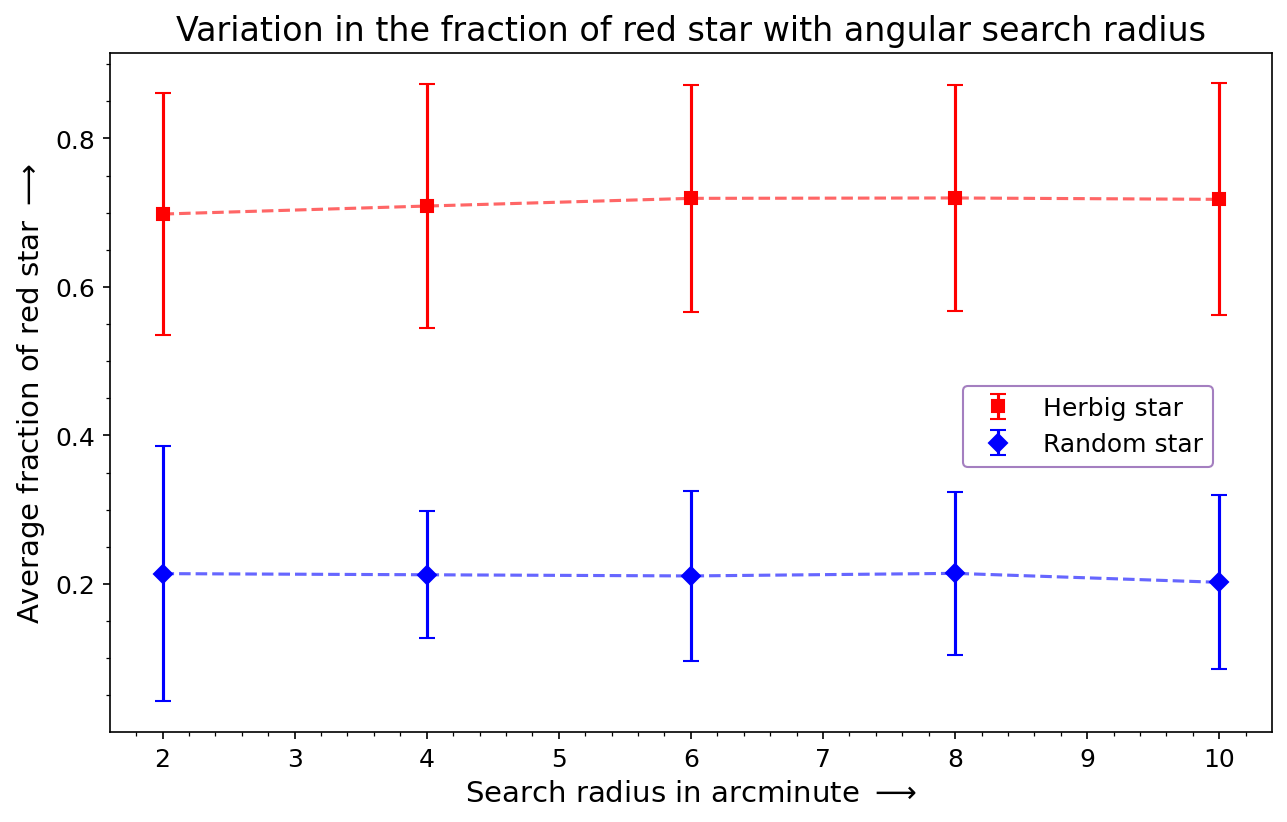

[0.6981633643713951, 0.7089618776722206, 0.7193105201100778, 0.7198278348425334, 0.7179604633521928] [0.21399461649461649, 0.21245556335278573, 0.21089075769702106, 0.21435610973759872, 0.2022831097565871]


In [44]:
search_radius = np.arange(2.0, 10.1, 2.0)
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (10, 6), dpi = 150)


# ax.set_title("Variation of fraction of red star with angular search radius\n", fontsize = 14 )
ax.plot(search_radius, avg_frac_star_her, c = 'red', linestyle = "--", alpha = 0.6)
ax.plot(search_radius, avg_frac_star_rand, c = 'blue', linestyle = '--', alpha = 0.6)

# Error bars
ax.errorbar(search_radius, avg_frac_star_her, sigma_herb, label = 'Herbig star',fmt='s', ecolor='red', color = 'red', capsize = 4)
ax.errorbar(search_radius, avg_frac_star_rand, yerr = (sigma_rand_lower, sigma_rand_upper), label = "Random star",fmt='D', ecolor='blue', color = 'blue', capsize = 4)

ax.minorticks_on()
ax.set_xlabel(r"Search radius in arcminute $\longrightarrow$", fontsize = 14 )
ax.set_ylabel(r"Average fraction of red star $\longrightarrow$", fontsize = 14 )
ax.legend(loc = 'center right', fontsize = 'large', framealpha = 0.5, edgecolor = '#4B0082', bbox_to_anchor=(0.96, 0.45))
ax.set_title("Variation in the fraction of red star with angular search radius", fontsize=16)
fig.savefig("red_frac_vari_rad.jpg", dpi = 600, bbox_inches='tight')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

print(avg_frac_star_her, avg_frac_star_rand)

In [45]:
np.average(avg_frac_star_her)

0.712844812069684

In [46]:
np.sqrt(np.var(avg_frac_star_her))

0.008334986042058805

In [47]:
np.average(avg_frac_star_rand)

0.21079603140772182

In [48]:
np.sqrt(np.var(avg_frac_star_rand))

0.004430303796759192

# Modified on the 24 Nov 2022


## Considering the size of the nebula

In [49]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result_new(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query = """SELECT TOP {}""".format(query_size) + """
        g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, d3.r_med_photogeo, d3.r_lo_photogeo, d3.r_hi_photogeo, (d3.r_hi_photogeo - d3.r_lo_photogeo)/(d3.r_med_photogeo) AS sigma_photogeo,
        g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr2.gaia_source as g, gaiadr2.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr2.tmass_best_neighbour as t, tmass_original_valid as tt, external.gaiaedr3_distance AS d3
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.tmass_oid = tt.tmass_oid)) AND (g.source_id = d3.source_id)
        """

    job = Gaia.launch_job(query)
    result = job.get_results()

    return result

In [50]:
randstar_20

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,dist_frac,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,mv,j_m,h_m,ks_m
0,59856764476922752,47.433523,19.411503,9.890270,0.046848,100.436653,99.850952,100.966087,0.005551,15.907440,17.483391,14.698281,2.785110,10.883481,16.246000,15.561,15.306000
1,146848750077282816,70.517012,24.010725,10.107328,0.022312,98.561348,98.384552,98.830284,0.002261,7.086922,7.316390,6.694567,0.621823,2.110103,14.498000,13.742,13.620000
2,312981486700500096,14.193589,32.494459,9.936203,0.017288,100.188339,100.026398,100.347954,0.001605,13.773635,14.741076,12.802568,1.938507,8.759737,14.319000,14.165,14.103000
3,362748097393004416,14.984224,34.442297,10.005069,0.045070,99.514137,98.984550,100.051117,0.005359,15.859979,17.362728,14.664412,2.698317,10.861079,13.987000,13.745,13.693000
4,461687651222322432,49.749567,58.439481,9.964083,0.017617,99.953873,99.785797,100.128395,0.001714,13.964098,15.074608,12.915493,2.159115,8.956285,16.856001,15.956,15.580000
5,462576778173176576,50.643719,60.716856,10.078152,0.023823,98.821953,98.621704,99.038483,0.002109,14.939083,16.326674,13.775648,2.551025,9.955988,16.554001,15.817,15.673000
6,474381856563417088,54.307283,60.575474,10.003175,0.039693,99.493614,99.105797,99.823410,0.003606,15.981009,17.867199,14.681762,3.185437,10.981699,10.538000,9.730,9.550000
7,509413529674071680,22.703879,59.702555,10.033937,0.019883,99.345024,99.174324,99.525673,0.001768,11.221929,11.753500,10.540051,1.213449,6.229286,15.563000,15.067,14.583000
8,750300897934316416,160.450729,34.777272,10.129899,0.045577,98.254036,97.922775,98.614243,0.003519,16.123632,17.706575,14.910587,2.795988,11.151658,16.643000,15.914,16.356001
9,1053784627100127872,156.682076,65.710861,9.807779,0.041711,101.486702,101.077377,101.971992,0.004408,16.119411,17.783390,14.857485,2.925905,11.077265,15.251000,14.630,14.318000


In [51]:
def distance_filter(frac_size_Cloud, search_radius):
    # Creating a list for storing the total number of stars around a Herbig Ae/Be star


    herb_frac_bf = []
    herb_frac_af = []
    rand_frac_bf = []
    rand_frac_af = []


    filter_dist = frac_size_Cloud    

    for i in range(len(herbig_20["Dist"])):
        
        # ------------------------------------------------
        # -----------   RANDOM STAR    -------------------

        # getting distance of star from table external.gaiaedr3_distance
        dist_star = randstar_20["r_med_photogeo"][i]
        result_star = get_gaia_result(10000, randstar_20["ra"][i], randstar_20['dec'][i], search_radius/60.0) # this will give radius in arc minutes 
        result_star = result_star[result_star["parallax_error"] < 0.3]          # Filter for selecting only good candidates
        # Before filtering
        rand_gk_bf = result_star['phot_g_mean_mag'] - result_star['ks_m']
        rand_mg_bf = result_star['mv']


        #After filter        
        max_dist_star = dist_star + dist_star * filter_dist
        min_dist_star = dist_star - dist_star * filter_dist
        result_star_af = result_star[(result_star["r_med_photogeo"] < max_dist_star) & (result_star["r_med_photogeo"] > min_dist_star)]

        rand_gk_af = result_star_af['phot_g_mean_mag'] - result_star_af['ks_m']
        rand_mg_af = result_star_af['mv']




        # -----------------------------------------------------
        # -----------   HERBIG Ae/Be STAR    -------------------


        dist_her = herbig_20["Dist"][i]
        
        result_her = get_gaia_result(10000, herbig_20["RAICRS"][i], herbig_20['DEICRS'][i], search_radius/60.0)  # this will give radius in arc minutes
        
        # Filter condition
        result_her = result_her[result_her["parallax_error"] < 0.3]

        her_gk_bf = result_her["phot_g_mean_mag"] - result_her['ks_m']
        her_mg_bf = result_her["mv"]        
        
      
        max_dist_her = dist_her + dist_her * filter_dist 
        min_dist_her = dist_her - dist_her * filter_dist 
        result_her_af = result_her[(result_her["r_med_photogeo"]<max_dist_her) & (result_her["r_med_photogeo"]>min_dist_her)]

        her_gk_af = result_her["phot_g_mean_mag"] - result_her['ks_m']
        her_mg_af = result_her["mv"]
        


        # Herbig star
        her_red_star_bf = counting_fun(her_mg_bf, her_gk_bf)

        if her_red_star_bf==0:
            herb_frac_bf.append(0)
        else:
            herb_frac_bf.append(her_red_star_bf/len(her_mg_bf))
            


        her_red_star_af = counting_fun(her_mg_af, her_gk_af)
        if her_red_star_af == 0:
            herb_frac_af.append(0)
        else:
            herb_frac_af.append(her_red_star_af/len(her_mg_af))

        

        """ Counting Red Object around a Random Star"""

        rand_red_star_bf = counting_fun(rand_mg_bf, rand_gk_bf)

        if rand_red_star_bf==0:
            rand_frac_bf.append(0)
        else:
            rand_frac_bf.append(rand_red_star_bf/len(rand_mg_bf))
        

        rand_red_star_af = counting_fun(rand_mg_af, rand_gk_af)
        
        if rand_red_star_af==0:
            rand_frac_af.append(0)
        else:
             rand_frac_af.append(rand_red_star_af/len(rand_mg_af))



    return rand_frac_bf, herb_frac_bf, rand_frac_af, herb_frac_af


In [52]:
  # fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)


    # ax.set_xlabel(r"$G - K$")
    # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

    # # Plotting the HR diagram for 1M sources
    # ax.scatter(g_k_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

    # # plotting the lines using just two points 

    # # ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
    # # ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
    # # ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

    # # plotting the boundries using the eqaution of straight line
    # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
    # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
    # ax.plot(equation3(y_values3), y_values3, color = 'orange')

    # # plotting/Placing herbig's surrounding stars in HR diagram(CMD)
    # ax.scatter(rand_gk, rand_mg, marker='o', color = 'k', s = 5, label = 'Random')
    # ax.scatter(her_gk, her_mg, marker='+', color = 'r', s = 5, label = 'HAeBe')

    # ax.minorticks_on()
    # ax.grid(True)
    # ax.legend()
    # ax.set_ylim(max(df.mg)+1, min(df.mg) -1)
    # plt.show()

# Considering new data release GAIA DR3

In [53]:

def get_gaiadr3_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query1 = """SELECT TOP {}""".format(query_size) + """
        g.ra, g.dec, g.parallax, g.parallax_error, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr3.gaia_source as g, gaiadr3.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr3.tmass_psc_xsc_best_neighbour as t, gaiadr3.tmass_psc_xsc_join AS tt,  tmass_original_valid as tmass, external.gaiaedr3_distance AS d3
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND  (g.source_id=t.source_id AND t.original_ext_source_id=tt.original_psc_source_id AND  tt.original_psc_source_id=tmass.designation))
        """

    job2 = Gaia.launch_job(query1)
    result1 = job2.get_results()

    return result1
